In [1]:
import os
import cv2
import random
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16

In [2]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
def load_image(x):
    byte_img=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img

In [4]:
train_images=tf.data.Dataset.list_files('aug_data/train/images/*.jpg',shuffle=False)
train_images=train_images.map(load_image)
train_images=train_images.map(lambda x: tf.image.resize(x,(120,120)))
train_images=train_images.map(lambda x: x/255)


In [5]:
test_images=tf.data.Dataset.list_files('aug_data/test/images/*.jpg',shuffle=False)
test_images=test_images.map(load_image)
test_images=test_images.map(lambda x: tf.image.resize(x,(120,120)))
test_images=test_images.map(lambda x: x/255)


In [6]:
val_images=tf.data.Dataset.list_files('aug_data/val/images/*.jpg',shuffle=False)
val_images=val_images.map(load_image)
val_images=val_images.map(lambda x: tf.image.resize(x,(120,120)))
val_images=val_images.map(lambda x: x/255)

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), "r",encoding="utf-8") as f:
        label=json.load(f)
    return [label['class']],label["bbox"]

In [8]:
train_labels=tf.data.Dataset.list_files('aug_data/train/labels/*.json',shuffle=False)
train_labels=train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [9]:
test_labels=tf.data.Dataset.list_files('aug_data/test/labels/*.json',shuffle=False)
test_labels=test_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [10]:
val_labels=tf.data.Dataset.list_files('aug_data/val/labels/*.json',shuffle=False)
val_labels=val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [11]:
test_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

In [12]:
train=tf.data.Dataset.zip((train_images,train_labels))
train=train.shuffle(5000)
train=train.batch(8)
train=train.prefetch(4)

In [13]:
test=tf.data.Dataset.zip((test_images,test_labels))
test=test.shuffle(5000)
test=test.batch(8)
test=test.prefetch(4)

In [14]:
val=tf.data.Dataset.zip((val_images,val_labels))
val=val.shuffle(5000)
val=val.batch(8)
val=val.prefetch(4)

In [15]:
sample=test.as_numpy_iterator()

In [16]:
res=sample.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


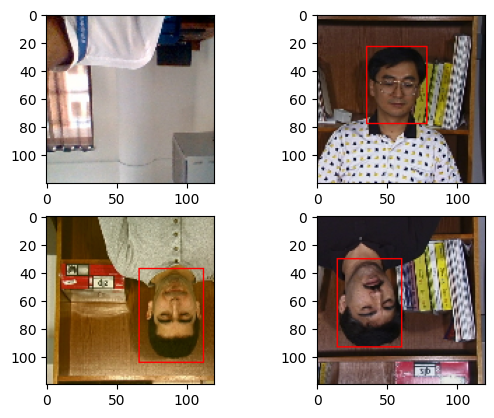

In [17]:
for i in range(4):
    sample_img=res[0][i]
    sample_coords=res[1][1][i]
    plt.subplot(2,2,i+1)
    cv2.rectangle(sample_img,tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),(255,0,0),1) 
    plt.imshow(sample_img)

# Builidng the Model

In [18]:
vgg=VGG16(include_top=False)

In [19]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [20]:
def build_model():
    input_layer=keras.layers.Input(shape=(120,120,3))
    vgg=VGG16(include_top=False)(input_layer)
    
    f1=keras.layers.GlobalMaxPooling2D()(vgg)
    class1=keras.layers.Dense(2048,activation="relu")(f1)
    class2=keras.layers.Dense(1,activation="sigmoid")(class1)
    
    f2=keras.layers.GlobalMaxPooling2D()(vgg)
    regress1=keras.layers.Dense(2048,activation="relu")(f2)
    regress2=keras.layers.Dense(4,activation="sigmoid")(regress1)
    
    facetracker=keras.Model(inputs=input_layer,outputs=[class2,regress2])
    
    return facetracker
    
    

In [21]:
facetracker=build_model()

In [22]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [23]:
X,y=train.as_numpy_iterator().next()

In [24]:
X.shape

(8, 120, 120, 3)

In [25]:
classes,coords=facetracker.predict(X)

In [26]:
classes,coords

(array([[0.66241556],
        [0.50780094],
        [0.6278105 ],
        [0.68413603],
        [0.57111293],
        [0.5751592 ],
        [0.6707217 ],
        [0.6029242 ]], dtype=float32),
 array([[0.4101278 , 0.5129753 , 0.4150053 , 0.54580426],
        [0.43864617, 0.48454377, 0.4759221 , 0.5836206 ],
        [0.4842508 , 0.60556686, 0.42325398, 0.47620812],
        [0.41552636, 0.43497065, 0.34896573, 0.6298702 ],
        [0.5052156 , 0.60273063, 0.42339307, 0.50950134],
        [0.4772336 , 0.6049194 , 0.4327737 , 0.5698871 ],
        [0.4301454 , 0.45073473, 0.33746865, 0.64903295],
        [0.45107916, 0.491401  , 0.49195188, 0.60671633]], dtype=float32))

In [27]:

len(train)

1628

In [28]:
batches_per_epoch=len(train)
lr_decay=(1./0.75 -1)/batches_per_epoch

In [29]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0001,decay=lr_decay)

In [30]:
def localization_loss(y_true, yhat):

    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2]-yhat[:, :2]))

    h_true = y_true[:, 3]-y_true[:, 1]
    w_true = y_true[:, 2]-y_true[:, 0]

    h_pred = yhat[:, 3]-yhat[:, 1]
    w_pred = yhat[:, 2]-yhat[:, 0]

    delta_size = tf.reduce_sum(
        tf.square(w_true-w_pred)+tf.square(h_true-h_pred))

    return delta_coord + delta_size


In [31]:
classloss=tf.keras.losses.BinaryCrossentropy()
regressloss=localization_loss

# Training the Nueral Network

In [32]:
class FaceTracker(keras.Model):
    def __init__(self,eyetracker,**kwargs) -> None:
        super().__init__(**kwargs)
        self.model=eyetracker
    
    def compile(self,opt,classloss,localization_loss,**kwargs):
        super().compile(**kwargs)
        self.closs=classloss
        self.lloss=localization_loss
        self.opt=opt
    
    def train_step(self,batch,**kwargs):
        X,y=batch
        
        with tf.GradientTape() as tape:
            classes,coords=self.model(X,training=True)
            
            batch_classloss=self.closs(y[0],classes)
            batch_localizationloss=self.lloss(tf.cast(y[1],tf.float32),coords)
            
            total_loss=batch_localizationloss+0.5*batch_classloss
            
            grad=tape.gradient(total_loss,self.model.trainable_variables)
            
        opt.apply_gradients(zip(grad,self.model.trainable_variables))
        
        return {"total_loss":total_loss,"class_loss":batch_classloss,"regress_loss":batch_localizationloss}
    
    def test_step(self,batch,**kwargs):
        X,y=batch
        classes,coords=self.model(X,training=False)
        batch_classloss=self.closs(y[0],classes)
        batch_localizationloss=self.lloss(tf.cast(y[1],tf.float32),coords)
        
        total_loss=batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss,"class_loss":batch_classloss,"regress_loss":batch_localizationloss}
    
    def call(self,X,**kwargs):
        return self.model(X,**kwargs)

In [33]:
model=FaceTracker(facetracker)

In [34]:
model.compile(opt,classloss,regressloss)

In [35]:
logdir="logs"

In [36]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [37]:
hist=model.fit(train,epochs=40,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/40
1628/1628 [==============================] - 259s 151ms/step - total_loss: 0.1951 - class_loss: 0.0486 - regress_loss: 0.1708 - val_total_loss: 0.0197 - val_class_loss: 5.7817e-06 - val_regress_loss: 0.0197
Epoch 2/40
1628/1628 [==============================] - 268s 149ms/step - total_loss: 0.0912 - class_loss: 0.0230 - regress_loss: 0.0796 - val_total_loss: 0.0253 - val_class_loss: 0.0220 - val_regress_loss: 0.0143
Epoch 3/40
1628/1628 [==============================] - 267s 145ms/step - total_loss: 0.0559 - class_loss: 0.0123 - regress_loss: 0.0498 - val_total_loss: 0.0034 - val_class_loss: 5.0848e-04 - val_regress_loss: 0.0031
Epoch 4/40
1628/1628 [==============================] - 240s 142ms/step - total_loss: 0.0280 - class_loss: 0.0054 - regress_loss: 0.0253 - val_total_loss: 0.0125 - val_class_loss: 5.3644e-06 - val_regress_loss: 0.0125
Epoch 5/40
1628/1628 [==============================] - 264s 144ms/step - total_loss: 0.0280 - class_loss: 0.0068 - regress_loss: 0.

# plotting the history

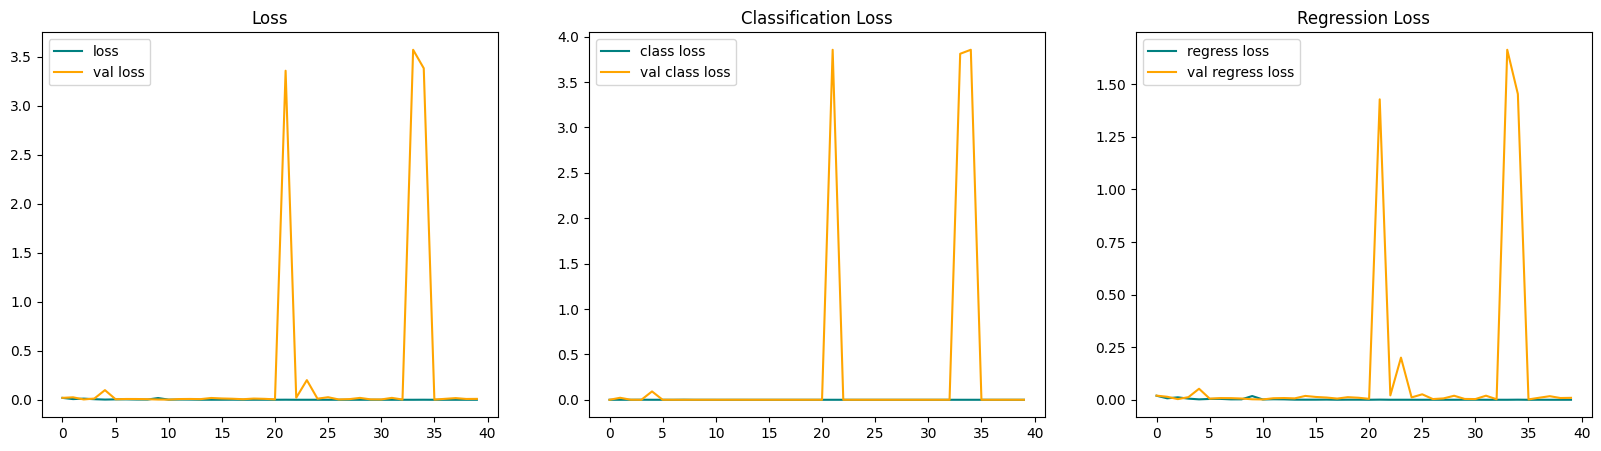

In [39]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()


ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# predicting 

In [40]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [41]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


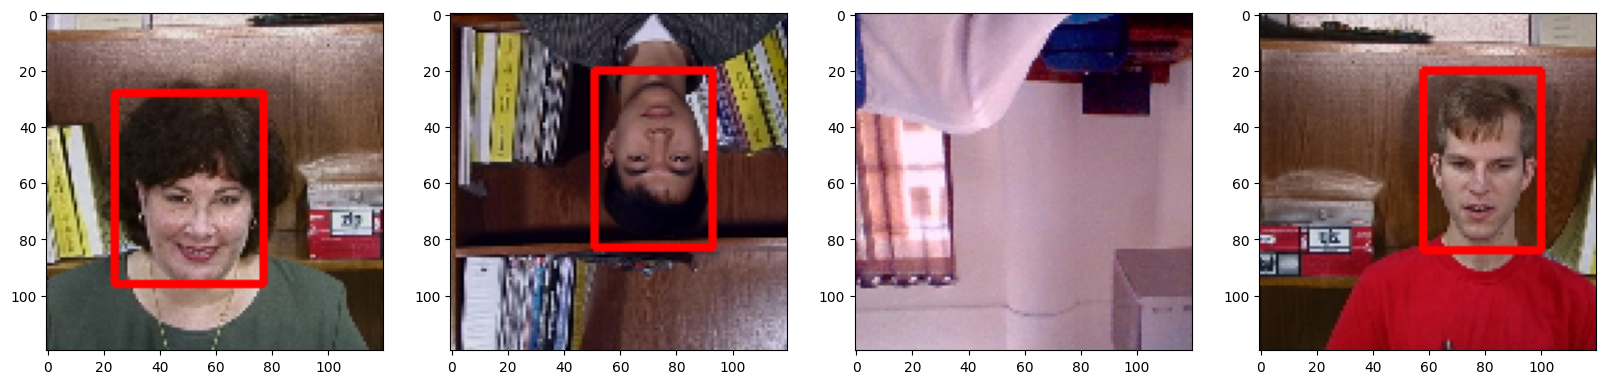

In [42]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)


# saving the model


In [43]:
facetracker.save("facetracker.h5")

# testing the model on video

In [39]:
cap=cv2.VideoCapture(0)

while True:
    _,frame=cap.read()
    
    frame=cv2.resize(frame, (450, 450))
    rgb=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    resized_frame=tf.image.resize(rgb,(120,120))
    
    yhat=facetracker.predict(np.expand_dims(resized_frame/255,0))
    sample_coords=yhat[1][0]
    
    if yhat[0]>0.5:
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2],[450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:],[450,450]).astype(int)),
                      (255,0,0),2)
    cv2.imshow("frame",frame)
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()